In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sun Jan 14 15:42:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [5]:
from model.main.enc_latent_dec import Model
from model.encoder.resblock_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.resblock_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [6]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.n_blocks = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [7]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 59.36157989501953
encoder.downs 5.989013671875
encoder.blocks 53.35693359375
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 19.359989166259766
decoder.linear 0.0234375
decoder.ups 5.9820556640625
decoder.blocks 13.31787109375
decoder.out_conv 0.036624908447265625
done


### Load

In [8]:
save_dir = '/data/scpark/save/lse/train01.13-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 593716
-rw-rw-r-- 1 scpark scpark    246692  1월 14 01:54 events.out.tfevents.1705164612.GPUSVR01
-rw-rw-r-- 1 scpark scpark 248134279  1월 14 01:50 save_0
-rw-rw-r-- 1 scpark scpark   1232900  1월 14 01:50 events.out.tfevents.1705163089.GPUSVR01
-rw-rw-r-- 1 scpark scpark 353231169  1월 14 01:44 save_10000
-rw-rw-r-- 1 scpark scpark   1005668  1월 14 01:24 events.out.tfevents.1705162071.GPUSVR01
-rw-rw-r-- 1 scpark scpark   1880266  1월 14 01:07 events.out.tfevents.1705160155.GPUSVR01
-rw-rw-r-- 1 scpark scpark    589796  1월 14 00:35 events.out.tfevents.1705159621.GPUSVR01
-rw-rw-r-- 1 scpark scpark    328196  1월 14 00:26 events.out.tfevents.1705159065.GPUSVR01
-rw-rw-r-- 1 scpark scpark   1288868  1월 14 00:17 events.out.tfevents.1705157484.GPUSVR01


### Dataset

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


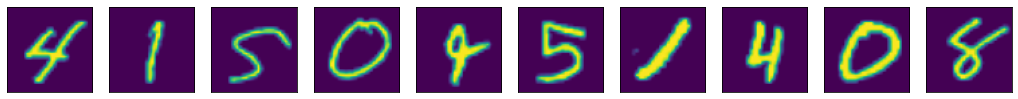

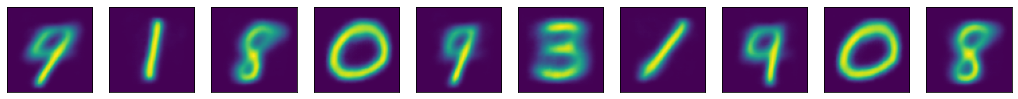

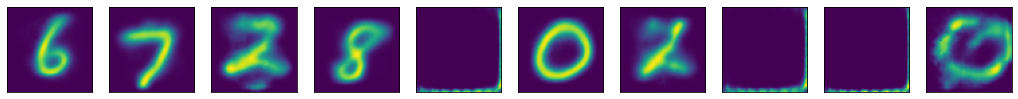

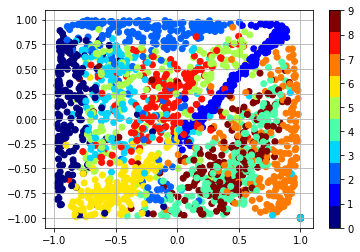

3001
lse_loss 0.011223316192626953
recon_loss 0.13314539194107056
3002
lse_loss 0.011566916480660439
recon_loss 0.13891400396823883
3003
lse_loss 0.012764106504619122
recon_loss 0.14260457456111908
3004
lse_loss 0.012018854729831219
recon_loss 0.13358071446418762
3005
lse_loss 0.011578288860619068
recon_loss 0.13188667595386505
3006
lse_loss 0.012323902919888496
recon_loss 0.135525643825531
3007
lse_loss 0.010980598628520966
recon_loss 0.1360073983669281
3008
lse_loss 0.011044519953429699
recon_loss 0.14058443903923035
3009
lse_loss 0.011208822019398212
recon_loss 0.1383967399597168
3010
lse_loss 0.013256627134978771
recon_loss 0.12586352229118347
3011
lse_loss 0.012092512100934982
recon_loss 0.1343887597322464
3012
lse_loss 0.010432188399136066
recon_loss 0.13913477957248688
3013
lse_loss 0.010291311889886856
recon_loss 0.14234650135040283
3014
lse_loss 0.01562493946403265
recon_loss 0.1336132287979126
3015
lse_loss 0.013097007758915424
recon_loss 0.14315104484558105
3016
lse_loss 0.0

lse_loss 0.011208703741431236
recon_loss 0.14236153662204742
3129
lse_loss 0.011760099790990353
recon_loss 0.14661745727062225
3130
lse_loss 0.012920326553285122
recon_loss 0.1413162797689438
3131
lse_loss 0.012979365885257721
recon_loss 0.14312121272087097
3132
lse_loss 0.012053116224706173
recon_loss 0.14076754450798035
3133
lse_loss 0.013018052093684673
recon_loss 0.14148806035518646
3134
lse_loss 0.012859133072197437
recon_loss 0.13865701854228973
3135
lse_loss 0.01097786147147417
recon_loss 0.13824352622032166
3136
lse_loss 0.013859489932656288
recon_loss 0.1377069652080536
3137
lse_loss 0.012287452816963196
recon_loss 0.1466239094734192
3138
lse_loss 0.013031220063567162
recon_loss 0.14346164464950562
3139
lse_loss 0.012651455588638783
recon_loss 0.14930221438407898
3140
lse_loss 0.014030233956873417
recon_loss 0.14214468002319336
3141
lse_loss 0.011840177699923515
recon_loss 0.14679233729839325
3142
lse_loss 0.014669536612927914
recon_loss 0.15572330355644226
3143
lse_loss 0.013

lse_loss 0.012669544667005539
recon_loss 0.14369803667068481
3256
lse_loss 0.011934525333344936
recon_loss 0.14627988636493683
3257
lse_loss 0.011721320450305939
recon_loss 0.13176146149635315
3258
lse_loss 0.012660553678870201
recon_loss 0.13685055077075958
3259
lse_loss 0.010702143423259258
recon_loss 0.1452234983444214
3260
lse_loss 0.013877484016120434
recon_loss 0.14162741601467133
3261
lse_loss 0.014488259330391884
recon_loss 0.1367044746875763
3262
lse_loss 0.012668387964367867
recon_loss 0.14191153645515442
3263
lse_loss 0.011119612492620945
recon_loss 0.13274815678596497
3264
lse_loss 0.01104211900383234
recon_loss 0.14218096435070038
3265
lse_loss 0.011000065132975578
recon_loss 0.1355763077735901
3266
lse_loss 0.0117491465061903
recon_loss 0.15207074582576752
3267
lse_loss 0.012197920121252537
recon_loss 0.14041772484779358
3268
lse_loss 0.012958405539393425
recon_loss 0.13749592006206512
3269
lse_loss 0.010959154926240444
recon_loss 0.14578953385353088
3270
lse_loss 0.01213

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        